In [1]:
import pandas as pd
import numpy as np
import argparse
import time
import math
import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem import Crippen
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdchem import GetPeriodicTable
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.ML.Descriptors import MoleculeDescriptors

from mordred import Calculator, descriptors
from padelpy import padeldescriptor, from_smiles

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
#from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import metrics
from sklearn.svm import SVR

import xgboost as xgb

import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Linear, Sequential, BatchNorm1d #, ReLU
from torch.nn.functional import relu
from torch.utils.data.sampler import SubsetRandomSampler


# Read Data from Files

In [2]:
full_train_padel_summation = pd.read_csv('../step3-train_test_split/xG_baruta_train_padel_summation.csv')
test_padel_summation = pd.read_csv('../step3-train_test_split/xG_baruta_test_padel_summation.csv')

full_Z_train = pd.read_csv('../step3-train_test_split/train_property.csv')
Z_test = pd.read_csv('../step3-train_test_split/test_property.csv')

In [3]:
#Padel
full_train_padel_summation=np.array(full_train_padel_summation)
test_padel_summation=np.array(test_padel_summation)

In [4]:
train_padel_summation, valida_padel_summation, Z_train, Z_valida = train_test_split(full_train_padel_summation, full_Z_train, test_size=0.1, random_state=142)

In [5]:
df_Z_train = Z_train
df_Z_valida = Z_valida
df_Z_test = Z_test

Z_train = np.array(Z_train) 
Z_valida = np.array(Z_valida) 
Z_test = np.array(Z_test)

Z_train = Z_train.ravel()
Z_valida = Z_valida.ravel()
Z_test = Z_test.ravel()

In [6]:
Z_train.shape, Z_valida.shape, Z_test.shape

((766,), (86,), (127,))

In [7]:
print(Z_valida[:8])

[3.94448267 2.95904139 4.34242268 1.48027275 2.01134194 2.5563025
 3.71       3.99997   ]


# Define the ANN model using PyTorch.

In [8]:
# Define the ANN model using PyTorch.

class ANNModel_padel(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(ANNModel_padel, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer to first hidden layer
        self.layers.append(nn.Linear(input_dim, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        
        # Adding subsequent hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
        
        # Last hidden layer to output layer
        self.layers.append(nn.Linear(hidden_layers[-1], 1))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


# Predicting log CMC using ANN - Padel with Arithmetic Mean

In [9]:
train_nn_padel_summation = torch.tensor(train_padel_summation, dtype=torch.float32)
Z_train_nn = torch.tensor(Z_train, dtype=torch.float32).view(-1, 1)

valida_nn_padel_summation = torch.tensor(valida_padel_summation, dtype=torch.float32)
Z_valida_nn = torch.tensor(Z_valida, dtype=torch.float32).view(-1, 1)

test_nn_padel_summation = torch.tensor(test_padel_summation, dtype=torch.float32)
Z_test_nn = torch.tensor(Z_test, dtype=torch.float32).view(-1, 1)

In [10]:
# Create the dataset and dataloader
train_dataset_padel_summation = TensorDataset(train_nn_padel_summation, Z_train_nn)
train_loader_padel_summation = DataLoader(train_dataset_padel_summation, batch_size=32, shuffle=False)

valida_dataset_padel_summation = TensorDataset(valida_nn_padel_summation, Z_valida_nn)
valida_loader_padel_summation = DataLoader(valida_dataset_padel_summation, batch_size=32, shuffle=False)

test_dataset_padel_summation = TensorDataset(test_nn_padel_summation, Z_test_nn)
test_loader_padel_summation = DataLoader(test_dataset_padel_summation, batch_size=32, shuffle=False)

In [11]:
# Parameters

input_dim_padel_summation = train_nn_padel_summation.shape[1]
hidden_layers_padel_summation = [512, 256, 256, 128, 64]
num_epochs_padel_summation = 1300
batch_size_padel_summation = 32
learning_rate_padel_summation = 0.00005
#train_nn_rdkit is a DataFrame or NumPy array with shape (num_samples, num_features)


In [12]:
# Create an instance of the ANN model
model_padel_summation = ANNModel_padel(input_dim_padel_summation,hidden_layers_padel_summation)

#Define the Loss Function and Optimizer:
criterion = nn.MSELoss()  # Mean Squared Error for regression tasks
optimizer = optim.Adam(model_padel_summation.parameters(), lr=learning_rate_padel_summation)


In [13]:
# Train the Model:
padel_summation_training_loss=[]
padel_summation_validation_loss=[]

for epoch in range(num_epochs_padel_summation):
    model_padel_summation.train()
    for X_batch, y_batch in train_loader_padel_summation:
        # Forward pass
        outputs = model_padel_summation(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    for X_val_batch, y_val_batch in valida_loader_padel_summation:
        # Forward pass
        outputs = model_padel_summation(X_val_batch)
        val_loss = criterion(outputs, y_val_batch)

    # Print loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs_padel_summation}], train_Loss: {loss.item():.4f}, valida_Loss: {val_loss.item():.4f}')
    # Append the losses
    padel_summation_training_loss.append(loss.item())
    padel_summation_validation_loss.append(val_loss.item())  

Epoch [1/1300], train_Loss: 10.1220, valida_Loss: 11.1731
Epoch [2/1300], train_Loss: 9.5886, valida_Loss: 10.6200
Epoch [3/1300], train_Loss: 8.5654, valida_Loss: 9.4951
Epoch [4/1300], train_Loss: 5.6157, valida_Loss: 6.3433
Epoch [5/1300], train_Loss: 1.6735, valida_Loss: 2.8034
Epoch [6/1300], train_Loss: 1.4379, valida_Loss: 2.6571
Epoch [7/1300], train_Loss: 1.3632, valida_Loss: 2.4721
Epoch [8/1300], train_Loss: 1.2834, valida_Loss: 2.3222
Epoch [9/1300], train_Loss: 1.2109, valida_Loss: 2.1720
Epoch [10/1300], train_Loss: 1.1402, valida_Loss: 2.0250
Epoch [11/1300], train_Loss: 1.0734, valida_Loss: 1.8821
Epoch [12/1300], train_Loss: 1.0097, valida_Loss: 1.7405
Epoch [13/1300], train_Loss: 0.9505, valida_Loss: 1.5996
Epoch [14/1300], train_Loss: 0.8932, valida_Loss: 1.4665
Epoch [15/1300], train_Loss: 0.8418, valida_Loss: 1.3466
Epoch [16/1300], train_Loss: 0.7976, valida_Loss: 1.2438
Epoch [17/1300], train_Loss: 0.7600, valida_Loss: 1.1565
Epoch [18/1300], train_Loss: 0.7279, 

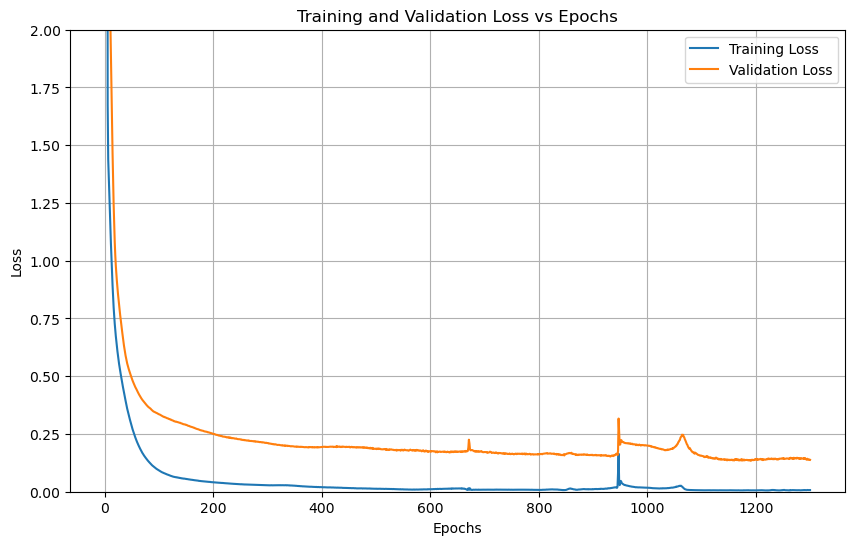

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_padel_summation + 1), padel_summation_training_loss, label='Training Loss')
plt.plot(range(1, num_epochs_padel_summation + 1), padel_summation_validation_loss, label='Validation Loss')
#plt.xlim([0, 7])
plt.ylim([0, 2.0])
# Adding titles and labels
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model Performance

In [23]:
# Evaluate the Model:

model_padel_summation.eval()
with torch.no_grad():
    Z_pred_train_padel_summation = model_padel_summation(train_nn_padel_summation)
    train_loss_padel_summation = criterion(Z_pred_train_padel_summation, Z_train_nn).item()
    r2_train_padel_summation = r2_score(Z_train_nn.cpu(), Z_pred_train_padel_summation.cpu())

    Z_pred_valida_padel_summation = model_padel_summation(valida_nn_padel_summation)
    valida_loss_padel_summation = criterion(Z_pred_valida_padel_summation, Z_valida_nn).item()
    r2_valida_padel_summation = r2_score(Z_valida_nn.cpu(), Z_pred_valida_padel_summation.cpu())

    Z_pred_test_padel_summation = model_padel_summation(test_nn_padel_summation)
    test_loss_padel_summation = criterion(Z_pred_test_padel_summation, Z_test_nn).item()
    r2_test_padel_summation = r2_score(Z_test_nn.cpu(), Z_pred_test_padel_summation.cpu())

print(f'Training Loss: {train_loss_padel_summation:.4f}')
print(f'Validation Loss: {valida_loss_padel_summation:.4f}')
print(f'Test Loss: {test_loss_padel_summation:.4f}')

print(f'Training R²: {r2_train_padel_summation:.4f}')
print(f'Validation R²: {r2_valida_padel_summation:.4f}')
print(f'Test R²: {r2_test_padel_summation:.4f}')

Training Loss: 0.0228
Validation Loss: 0.1507
Test Loss: 0.0992
Training R²: 0.9848
Validation R²: 0.9175
Test R²: 0.9406


In [24]:
# === Save the model weights ===
torch.save(model_padel_summation.state_dict(), 'ann_padel_summation_weights.pth')
print("Model weights saved.")

import json
model_config = {
    "input_dim": input_dim_padel_summation,
    "hidden_layers": hidden_layers_padel_summation
}
with open('ann_padel_summation_config.json', 'w') as f:
    json.dump(model_config, f)


Model weights saved.


## Parity Plot

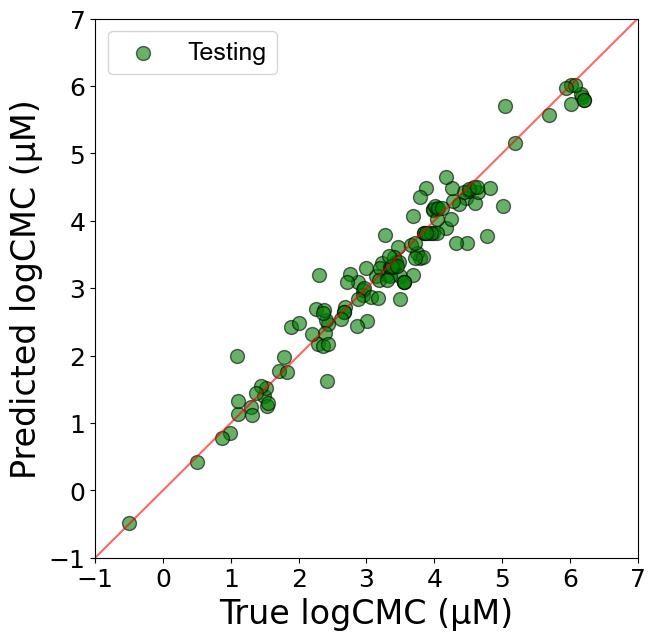

In [25]:
label_fs = 24
legend_label_fs = 18
ticks_fs = 18
marker_s = 100
ap = 0.6

plt.rcParams["figure.figsize"] = (7, 7)
legend_font_properties = {'family': 'arial','size': legend_label_fs}#,'weight': 'bold'}
plt.scatter(Z_test_nn.numpy(), Z_pred_test_padel_summation.numpy(),s=marker_s, alpha=ap, color='green', edgecolor='black',label="Testing") 
plt.plot([-1,7], [-1,7], alpha=ap, color='red')
plt.xlim([-1, 7])
plt.ylim([-1, 7])
plt.xlabel('True logCMC (\u03bcM)', fontsize=label_fs)
plt.ylabel('Predicted logCMC (\u03bcM)', fontsize=label_fs)
plt.xticks(fontsize=ticks_fs)
plt.yticks(fontsize=ticks_fs)
# Adding legend
plt.legend(prop=legend_font_properties)
plt.show()


## Classify parity plot points based on headgroup charges

In [26]:
import pandas as pd
import numpy as np

# Load data
total_smiles = pd.read_csv('../dataset/total_smile.csv')
train_smiles = pd.read_csv('../step3-train_test_split/train_smile.csv')
test_smiles = pd.read_csv('../step3-train_test_split/test_smile.csv')
train_property = pd.read_csv('../step3-train_test_split/train_property.csv')
test_property = pd.read_csv('../step3-train_test_split/test_property.csv')

# Convert prediction arrays
Predicted_test_value = Z_pred_test_padel_summation.numpy().flatten()
predicted_train_value = Z_pred_train_padel_summation.numpy().flatten()
predicted_valida_value = Z_pred_valida_padel_summation.numpy().flatten()

# Step 1: Use index-preserved dataframes to reconstruct train_df and test_df
# -- Combine training and validation sets
train_df = train_smiles.loc[df_Z_train.index].copy()
valida_df = train_smiles.loc[df_Z_valida.index].copy()

train_df['true_log_CMC'] = df_Z_train.values
valida_df['true_log_CMC'] = df_Z_valida.values

train_df['category'] = 'train'
valida_df['category'] = 'train'

train_df['predicted_log_CMC'] = predicted_train_value
valida_df['predicted_log_CMC'] = predicted_valida_value

# Concatenate train + validation
combined_train_df = pd.concat([train_df, valida_df], ignore_index=True)


# Step 2: Construct test_df
test_df = test_smiles.copy()
test_df['true_log_CMC'] = df_Z_test.values
test_df['category'] = 'test'
test_df['predicted_log_CMC'] = Predicted_test_value

# Step 3: Combine all
combined_test_train_df = pd.concat([combined_train_df, test_df], ignore_index=True)



# Step 1: Identify duplicated keys
key_cols = ['smile_A', 'mol_fraction_A', 'smile_B', 'mol_fraction_B']
duplicated_keys = combined_test_train_df.duplicated(subset=key_cols, keep=False)

# Step 2: Remove all duplicated entries (i.e., keep only unique ones)
clean_combined_df = combined_test_train_df[~duplicated_keys].copy()

# Step 3: Merge with total_smiles
merged_df = total_smiles.merge(
    clean_combined_df,
    on=key_cols,
    how='left'
)


In [27]:
merged_df

,smile_A,mol_fraction_A,smile_B,mol_fraction_B,true_log_CMC,category,predicted_log_CMC
0,CCCCCCCCCCCCOS(=O)(=O)[O-],0.0,CCCCCCCCCCCCCCCC[N+](C)(C)C,1.0,2.857332,test,2.436637
1,CCCCCCCCCCCCOS(=O)(=O)[O-],0.1,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.9,0.991226,train,1.051794
2,CCCCCCCCCCCCOS(=O)(=O)[O-],0.2,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.8,0.991226,test,0.853134
3,CCCCCCCCCCCCOS(=O)(=O)[O-],0.3,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.7,0.903090,train,0.772793
4,CCCCCCCCCCCCOS(=O)(=O)[O-],0.4,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.6,0.732394,train,0.735101
...,...,...,...,...,...,...,...
974,CCCCCCCCCCCCCCOCC(O)Cn1cc[n+](CCC[n+]2ccn(CC(O...,0.5,CCCCCCCCCCCCCCOCC(O)Cn1cc[n+](CCC[n+]2ccn(CC(O...,0.5,1.851000,train,1.837447
975,CCCCCCCCCCCCCCC(CSCCSCC(CCCCCCCCCCCCCC)[n+]1cc...,0.5,CCCCCCCCCCCCCCC(CSCCSCC(CCCCCCCCCCCCCC)[n+]1cc...,0.5,1.342000,train,1.249043
976,CCCCCCCCCCCCCCC(CSCCCSCC(CCCCCCCCCCCCCC)[n+]1c...,0.5,CCCCCCCCCCCCCCC(CSCCCSCC(CCCCCCCCCCCCCC)[n+]1c...,0.5,1.322000,train,1.270794
977,CCCCCCCCCCCCCCC(CSCCCCSCC(CCCCCCCCCCCCCC)[n+]1...,0.5,CCCCCCCCCCCCCCC(CSCCCCSCC(CCCCCCCCCCCCCC)[n+]1...,0.5,1.301000,train,1.270691


In [28]:
from rdkit import Chem

def get_formal_charge(smile):
    try:
        mol = Chem.MolFromSmiles(smile)
        if mol is None:
            print(f"Warning: Could not parse SMILES: {smile}")
            return np.nan
        return sum(atom.GetFormalCharge() for atom in mol.GetAtoms())
    except Exception as e:
        print(f"Error parsing SMILES {smile}: {e}")
        return np.nan

merged_df['charge_a'] = merged_df['smile_A'].apply(get_formal_charge)
merged_df['charge_b'] = merged_df['smile_B'].apply(get_formal_charge)


In [29]:
def assign_category(row):
    a = int(round(row['charge_a']))
    b = int(round(row['charge_b']))
    if pd.isna(a) or pd.isna(b):
        return 'unknown'
    if a > 0 and b > 0:
        return 'Cationic - Cationic'
    elif (a > 0 and b == 0) or (a == 0 and b > 0):
        return 'Cationic - Nonionic'
    elif (a > 0 and b < 0) or (a < 0 and b > 0):
        return 'Cationic - Anionic'
    elif a == 0 and b == 0:
        return 'Nonionic - Nonionic'
    elif (a == 0 and b < 0) or (a < 0 and b == 0):
        return 'Anionic - Nonionic'
    elif a < 0 and b < 0:
        return 'Anionic - Anionic'
    else:
        return 'other'


merged_df['charge_category'] = merged_df.apply(assign_category, axis=1)


In [30]:
# merged_df.to_csv('combined_prediction_results.csv', index=False)
merged_df

,smile_A,mol_fraction_A,smile_B,mol_fraction_B,true_log_CMC,category,predicted_log_CMC,charge_a,charge_b,charge_category
0,CCCCCCCCCCCCOS(=O)(=O)[O-],0.0,CCCCCCCCCCCCCCCC[N+](C)(C)C,1.0,2.857332,test,2.436637,-1,1,Cationic - Anionic
1,CCCCCCCCCCCCOS(=O)(=O)[O-],0.1,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.9,0.991226,train,1.051794,-1,1,Cationic - Anionic
2,CCCCCCCCCCCCOS(=O)(=O)[O-],0.2,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.8,0.991226,test,0.853134,-1,1,Cationic - Anionic
3,CCCCCCCCCCCCOS(=O)(=O)[O-],0.3,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.7,0.903090,train,0.772793,-1,1,Cationic - Anionic
4,CCCCCCCCCCCCOS(=O)(=O)[O-],0.4,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.6,0.732394,train,0.735101,-1,1,Cationic - Anionic
...,...,...,...,...,...,...,...,...,...,...
974,CCCCCCCCCCCCCCOCC(O)Cn1cc[n+](CCC[n+]2ccn(CC(O...,0.5,CCCCCCCCCCCCCCOCC(O)Cn1cc[n+](CCC[n+]2ccn(CC(O...,0.5,1.851000,train,1.837447,2,2,Cationic - Cationic
975,CCCCCCCCCCCCCCC(CSCCSCC(CCCCCCCCCCCCCC)[n+]1cc...,0.5,CCCCCCCCCCCCCCC(CSCCSCC(CCCCCCCCCCCCCC)[n+]1cc...,0.5,1.342000,train,1.249043,2,2,Cationic - Cationic
976,CCCCCCCCCCCCCCC(CSCCCSCC(CCCCCCCCCCCCCC)[n+]1c...,0.5,CCCCCCCCCCCCCCC(CSCCCSCC(CCCCCCCCCCCCCC)[n+]1c...,0.5,1.322000,train,1.270794,2,2,Cationic - Cationic
977,CCCCCCCCCCCCCCC(CSCCCCSCC(CCCCCCCCCCCCCC)[n+]1...,0.5,CCCCCCCCCCCCCCC(CSCCCCSCC(CCCCCCCCCCCCCC)[n+]1...,0.5,1.301000,train,1.270691,2,2,Cationic - Cationic


In [31]:
print(merged_df['charge_category'].value_counts())


charge_category
Cationic - Cationic    250
Nonionic - Nonionic    225
Cationic - Anionic     145
Anionic - Anionic      145
Anionic - Nonionic     138
Cationic - Nonionic     76
Name: count, dtype: int64


In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Step 1: Filter test points
categorized_test_df = merged_df[merged_df['category'] == 'test'].copy()


# Step 2: Drop rows with missing values in necessary columns
categorized_test_df = categorized_test_df.dropna(subset=['true_log_CMC', 'predicted_log_CMC', 'charge_category'])




In [33]:
categorized_test_df

,smile_A,mol_fraction_A,smile_B,mol_fraction_B,true_log_CMC,category,predicted_log_CMC,charge_a,charge_b,charge_category
0,CCCCCCCCCCCCOS(=O)(=O)[O-],0.00,CCCCCCCCCCCCCCCC[N+](C)(C)C,1.00,2.857332,test,2.436637,-1,1,Cationic - Anionic
2,CCCCCCCCCCCCOS(=O)(=O)[O-],0.20,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.80,0.991226,test,0.853134,-1,1,Cationic - Anionic
9,CCCCCCCCCCCCOS(=O)(=O)[O-],0.90,CCCCCCCCCCCCCCCC[N+](C)(C)C,0.10,1.089905,test,1.996705,-1,1,Cationic - Anionic
11,CCCCCCCCCCCCOS(=O)(=O)[O-],1.00,CCCCCCCCCCOS(=O)(=O)[O-],0.00,3.906015,test,3.812652,-1,-1,Anionic - Anionic
15,CCCCCCCCCCCCOS(=O)(=O)[O-],0.40,CCCCCCCCCCOS(=O)(=O)[O-],0.60,4.120218,test,4.196455,-1,-1,Anionic - Anionic
...,...,...,...,...,...,...,...,...,...,...
497,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,0.25,CCCCCCCCn1cc[n+](C)c1,0.75,2.949390,test,2.896230,0,1,Cationic - Nonionic
500,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,1.00,CCCCCCCCn1cc[n+](C)c1,0.00,4.477121,test,3.674856,0,1,Cationic - Nonionic
501,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,0.00,CCCCCCCCCCn1cc[n+](C)c1,1.00,4.774517,test,3.776012,0,1,Cationic - Nonionic
503,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,0.50,CCCCCCCCCCn1cc[n+](C)c1,0.50,2.204120,test,2.318640,0,1,Cationic - Nonionic


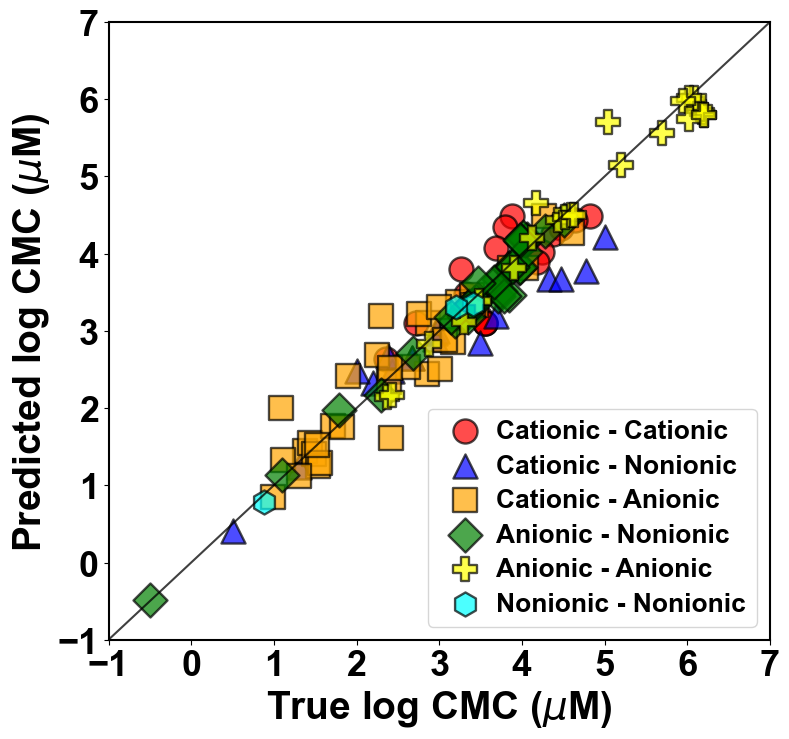

In [41]:
# === Custom legend order ===
desired_order = [
    'Cationic - Cationic',
    'Cationic - Nonionic',
    'Cationic - Anionic',
    'Anionic - Nonionic',
    'Anionic - Anionic',
    'Nonionic - Nonionic'
]

custom_colors = {
    'Cationic - Cationic': 'red',  # Muted Blue (Cool & Distinct)
    'Cationic - Nonionic': 'blue',  # Soft Orange (Warm & Eye-Catching)
    'Cationic - Anionic': 'orange',   # Teal Green (Refreshing & Different)
    'Anionic - Nonionic': 'green',    # Soft Red (Rich & Noticeable)
    'Anionic - Anionic': 'yellow',    # Elegant Purple (Balanced & Subtle)
    'Nonionic - Nonionic': 'cyan',  # Forest Green (Deep & Natural)
}



# Step 3: Define unique categories and color map
unique_categories = categorized_test_df['charge_category'].unique()

# Assign colors manually based on the order
#colors = plt.cm.tab10(np.linspace(0, 1, len(desired_order)))
#color_map = dict(zip(desired_order, colors))

markers = ['o', '^', 's', 'D', 'P', 'h', 'X', 'h', '+', 'x']
marker_map = dict(zip(desired_order, markers))

# Step 4: Plot
plt.figure(figsize=(8, 7.5))

for cat in desired_order:
    subset = categorized_test_df[categorized_test_df['charge_category'] == cat]
    plt.scatter(subset['true_log_CMC'], 
                subset['predicted_log_CMC'],
                label=cat, 
                color=custom_colors[cat], 
                marker=marker_map[cat],
                s=300, 
                edgecolors='k',  # No edge
                linewidths=1.7,
                alpha=0.7)

# Step 5: Add parity line
lims = [-1,7]
plt.plot(lims, lims, '-', alpha=0.75, color='k')

# set x y limits
plt.xlim([-1, 7])
plt.ylim([-1, 7])

# Final plot settings
plt.xlabel("True log CMC ($\mu$M)", fontsize=28, fontname='Arial', fontweight='bold')
plt.ylabel("Predicted log CMC ($\mu$M)", fontsize=28, fontname='Arial', fontweight='bold')

plt.xticks(fontsize=26, fontname='Arial', fontweight='bold')
plt.yticks(fontsize=26, fontname='Arial', fontweight='bold')
#plt.title("Parity Plot of Test Data by Charge Category")
plt.legend(
    loc='lower right',
    #fontsize=12,
    prop={'size': 19, 'weight': 'bold', 'family': 'Arial'},
    labelspacing=0.4,        # vertical space between entries
    handletextpad=0.2        # space between marker and text
)

# Add black border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.grid(False)
plt.tight_layout()
plt.savefig('parity_plot_ANN_Padel_summation.png', dpi=600, bbox_inches='tight')
plt.show()